In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Dataset 1 V1 (70:30)
# EN 97%
# CNN 93%
# Eff 95%

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Define Labels

In [3]:
labels = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [28]:
labels_1=['MD', 'MOD', 'ND', 'VMD']

In [4]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
# converted into array

Xtrain = np.array(X_train)
Ytrain = np.array(Y_train)

100%|██████████| 448/448 [00:01<00:00, 320.26it/s]


In [5]:
Xtrain.shape

(6400, 150, 150, 3)

In [6]:
Ytrain.shape

(6400,)

In [7]:
Xtrain,Ytrain = shuffle(Xtrain, Ytrain, random_state=42)

## Train test split which is divided train dataset and validation dataset

In [8]:
xtrain,xtest, Ytrain,ytest = train_test_split(Xtrain, Ytrain,test_size=0.1, random_state=42)

In [9]:
xtrain.shape

(5760, 150, 150, 3)

In [10]:
Ytrain.shape

(5760,)

In [11]:
xtest.shape

(640, 150, 150, 3)

In [13]:
ytest.shape

(1878,)

## Converting labels into One hot encoder

In [12]:
ytrain_new = []
ytest_new = []

for i in Ytrain:
    ytrain_new.append(labels.index(i))#Converting String Label to integer i.e
                                       
ytrain = to_categorical(ytrain_new) #Converts a class vector (integers) to binary class matrix

for i in ytest:
    ytest_new.append(labels.index(i))

ytest = to_categorical(ytest_new)

In [15]:
ytrain.shape

(16897, 5)

In [13]:
ytest.shape

(640, 4)

# DENSENET MODEL

In [14]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(image_size, image_size, 3)) 

29084464/29084464 [==============================] - 0s 0us/step


In [15]:
# Output of model

model = model_d.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=model_d.input, outputs=model)

In [16]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [17]:
model.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [18]:
history=model.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))
#history = model.load_weights('/kaggle/input/h-5-files/DENSE_90_10.h5')
#history=model.fit(xtrain,ytrain,epochs=20,validation_data=(xtest,ytest))

Epoch 1/50
180/180 [==============================] - 117s 184ms/step - loss: 0.9448 - accuracy: 0.8167 - precision: 0.6508 - recall: 0.5755 - auc: 0.8653 - val_loss: 3.2772 - val_accuracy: 0.7711 - val_precision: 0.5425 - val_recall: 0.5391 - val_auc: 0.7684
Epoch 2/50
180/180 [==============================] - 31s 175ms/step - loss: 0.5398 - accuracy: 0.8972 - precision: 0.8130 - recall: 0.7648 - auc: 0.9497 - val_loss: 1.1301 - val_accuracy: 0.8121 - val_precision: 0.6305 - val_recall: 0.6000 - val_auc: 0.8509
Epoch 3/50
180/180 [==============================] - 32s 179ms/step - loss: 0.2984 - accuracy: 0.9438 - precision: 0.8959 - recall: 0.8769 - auc: 0.9831 - val_loss: 2.9629 - val_accuracy: 0.6930 - val_precision: 0.3852 - val_recall: 0.3828 - val_auc: 0.6996
Epoch 4/50
180/180 [==============================] - 32s 178ms/step - loss: 0.1938 - accuracy: 0.9634 - precision: 0.9303 - recall: 0.9227 - auc: 0.9926 - val_loss: 1.1326 - val_accuracy: 0.8398 - val_precision: 0.6861 - 

In [19]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/DENSE_D2_90_10.csv', index=False)

# Save the model itself
model.save('/kaggle/working/DENSE_D2_90_10.h5')

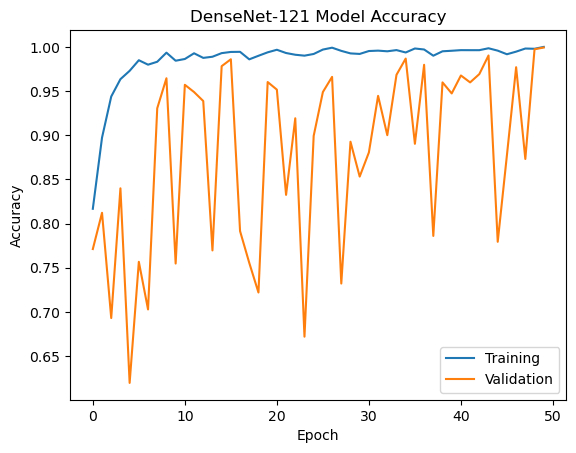

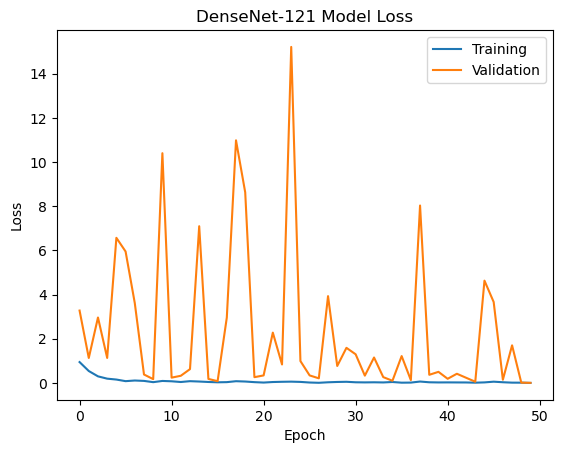

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet-121 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('dense_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet-121 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('dense_loss.png', dpi=300) # Save plot as PNG
plt.show()

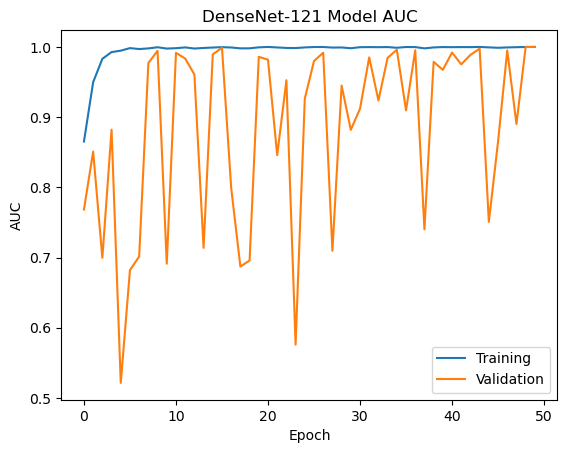

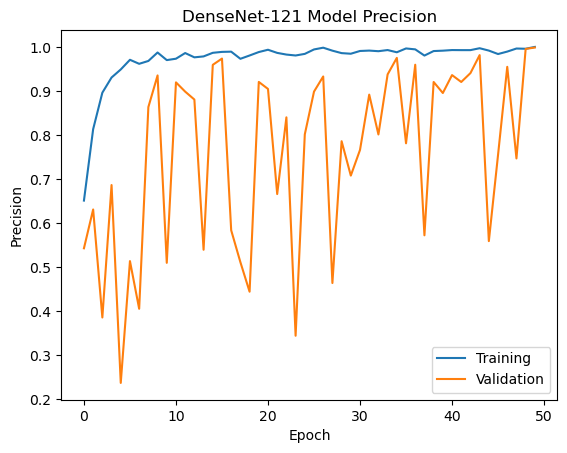

In [24]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('DenseNet-121 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('DenseNet-121_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('DenseNet-121 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('DenseNet-121_precision.png', dpi=300) # Save plot as PNG
plt.show()

In [25]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(ytest, axis=1)
print(classification_report(actual_label, pred , target_names = labels))

20/20 [==============================] - 3s 48ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00        94
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       1.00      1.00      1.00       321
VeryMildDemented       1.00      1.00      1.00       213

        accuracy                           1.00       640
       macro avg       1.00      1.00      1.00       640
    weighted avg       1.00      1.00      1.00       640



In [26]:
accuracy_score(actual_label, pred)

0.9984375

In [24]:
from sklearn.metrics import precision_score

precision = precision_score(actual_label, pred, average='weighted')

print("Precision Score:", precision)




Precision Score: 0.9963194611169567


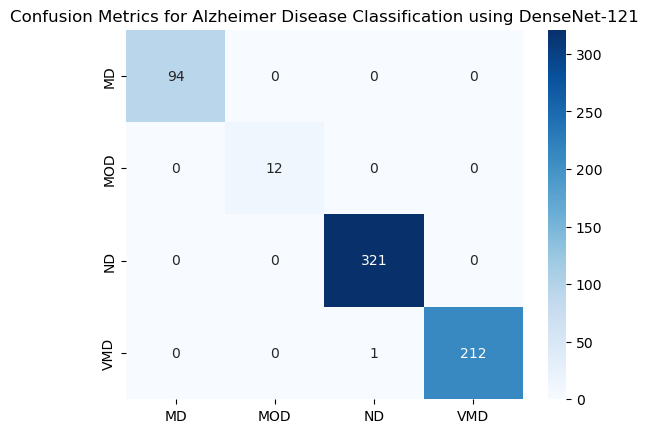

In [41]:
Cm=confusion_matrix(actual_label,pred)
ax=plt.axes()
sns.heatmap(Cm, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using DenseNet-121")
plt.savefig('densenet_confusion_97%.png', dpi=300) # Save plot as PNG
plt.show()

## Loss and Accuracy Measurement graph

## CNN MODEL

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [31]:
#Create the model
cnn=Sequential()
#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=(image_size, image_size, 3)))
#add a Max Pooling layer
cnn.add(MaxPooling2D())
#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Add 32 convolutions
cnn.add(Conv2D(32,(2,2),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Flatten before adding fully connected layer
cnn.add(Flatten())
#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))
#Add another hidden layer with 50 nodes
cnn.add(Dense(50,activation='relu'))
#Add final output layer with 4 output nodes using softmax
cnn.add(Dense(4,activation='softmax'))

In [32]:
cnn.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [33]:
history1=cnn.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))
#history1 = cnn.load_weights('/kaggle/input/h-5-files/CNN_90_10.h5')

Epoch 1/50
180/180 [==============================] - 8s 25ms/step - loss: 1.8823 - accuracy: 0.8052 - precision: 0.6462 - recall: 0.4875 - auc: 0.8423 - val_loss: 0.9276 - val_accuracy: 0.8012 - val_precision: 0.6427 - val_recall: 0.4609 - val_auc: 0.8410
Epoch 2/50
180/180 [==============================] - 4s 23ms/step - loss: 0.7327 - accuracy: 0.8399 - precision: 0.7170 - recall: 0.5939 - auc: 0.9021 - val_loss: 0.6931 - val_accuracy: 0.8480 - val_precision: 0.7328 - val_recall: 0.6172 - val_auc: 0.9126
Epoch 3/50
180/180 [==============================] - 4s 23ms/step - loss: 0.6177 - accuracy: 0.8710 - precision: 0.7675 - recall: 0.6944 - auc: 0.9311 - val_loss: 0.6371 - val_accuracy: 0.8574 - val_precision: 0.7342 - val_recall: 0.6734 - val_auc: 0.9236
Epoch 4/50
180/180 [==============================] - 4s 23ms/step - loss: 0.4132 - accuracy: 0.9169 - precision: 0.8481 - recall: 0.8134 - auc: 0.9684 - val_loss: 0.4940 - val_accuracy: 0.9039 - val_precision: 0.8251 - val_recal

In [34]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history1.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/CNN__D2_90_10.csv', index=False)

# Save the model itself
cnn.save('/kaggle/working/CNN_D2_90_10.h5')

In [35]:
pred1 = cnn.predict(xtest)
pred1 = np.argmax(pred1, axis=1)
actual_label1 = np.argmax(ytest, axis=1)
print(classification_report(actual_label1, pred1 , target_names = labels))

20/20 [==============================] - 0s 7ms/step
                  precision    recall  f1-score   support

    MildDemented       0.98      0.94      0.96        94
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       0.97      0.99      0.98       321
VeryMildDemented       0.98      0.97      0.97       213

        accuracy                           0.97       640
       macro avg       0.98      0.97      0.98       640
    weighted avg       0.98      0.97      0.97       640



In [36]:
accuracy_score(actual_label1, pred1)

0.975

In [33]:
from sklearn.metrics import precision_score

precision = precision_score(actual_label1, pred1, average='weighted')

print("Precision Score:", precision)

Precision Score: 0.9947401854895321


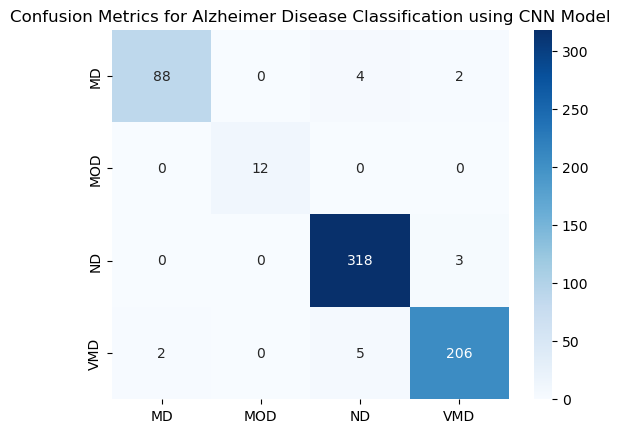

In [37]:
Cm1=confusion_matrix(actual_label1,pred1)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using CNN Model")
plt.savefig('cnn_confusion.png', dpi=300) # Save plot as PNG
plt.show()

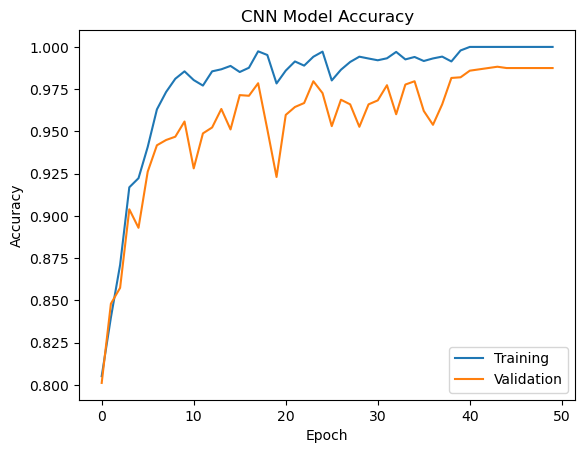

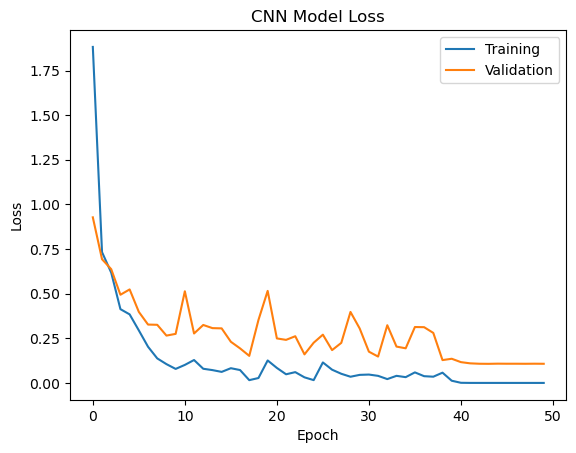

In [38]:
# Plot the training and validation accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_loss.png', dpi=300) # Save plot as PNG
plt.show()

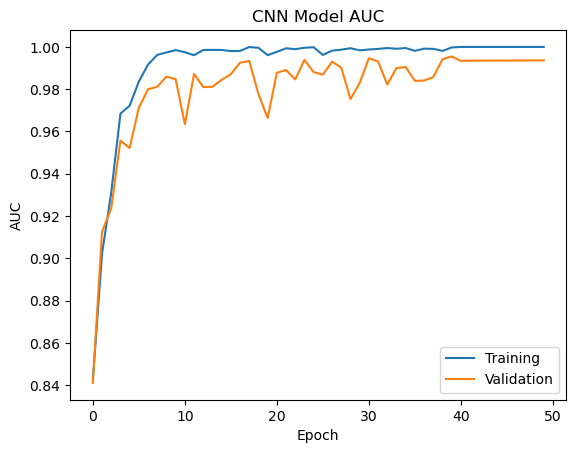

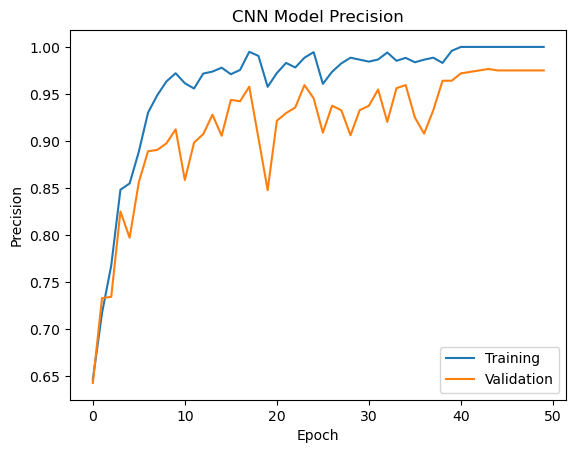

In [39]:
# Plot the training and validation auc
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('CNN Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history1.history['precision'])
plt.plot(history1.history['val_precision'])
plt.title('CNN Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('cnn_precision.png', dpi=300) # Save plot as PNG
plt.show()

## Efficient NetB7 Model

In [65]:
from tensorflow.keras.applications import EfficientNetB7

In [66]:
efficientnetB7= EfficientNetB7(include_top=False,weights='imagenet',input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 1s 0us/step


In [67]:
# Output of model

model2 = efficientnetB7.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=efficientnetB7.input, outputs=model2)

In [68]:
model2.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [69]:
history2=model2.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50


2023-11-11 15:21:43.854457: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


180/180 [==============================] - 303s 850ms/step - loss: 0.8175 - accuracy: 0.8442 - precision: 0.7449 - recall: 0.5731 - auc: 0.9005 - val_loss: 2.5499 - val_accuracy: 0.7309 - val_precision: 0.4588 - val_recall: 0.4266 - val_auc: 0.7244
Epoch 2/50
180/180 [==============================] - 147s 816ms/step - loss: 0.3793 - accuracy: 0.9273 - precision: 0.8681 - recall: 0.8361 - auc: 0.9739 - val_loss: 0.5885 - val_accuracy: 0.9156 - val_precision: 0.8333 - val_recall: 0.8281 - val_auc: 0.9614
Epoch 3/50
180/180 [==============================] - 147s 815ms/step - loss: 0.1617 - accuracy: 0.9712 - precision: 0.9464 - recall: 0.9378 - auc: 0.9942 - val_loss: 0.5636 - val_accuracy: 0.9250 - val_precision: 0.8511 - val_recall: 0.8484 - val_auc: 0.9624
Epoch 4/50
180/180 [==============================] - 147s 816ms/step - loss: 0.1039 - accuracy: 0.9822 - precision: 0.9664 - recall: 0.9625 - auc: 0.9971 - val_loss: 0.2094 - val_accuracy: 0.9652 - val_precision: 0.9311 - val_reca

In [79]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history2.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/EFF_D2_90_10.csv', index=False)

# Save the model itself
model2.save('/kaggle/working/EFF_D2_90_10.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [ ]:
history2 = model2.load_weights('/kaggle/input/h-files/efficientb7.h5')


In [71]:
pred2 = model2.predict(xtest)
pred2 = np.argmax(pred2, axis=1)
actual_label2 = np.argmax(ytest, axis=1)
print(classification_report(actual_label2, pred2,target_names = labels))

20/20 [==============================] - 8s 177ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      0.98      0.99        94
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       0.99      1.00      0.99       321
VeryMildDemented       1.00      0.99      1.00       213

        accuracy                           0.99       640
       macro avg       1.00      0.99      0.99       640
    weighted avg       0.99      0.99      0.99       640



In [72]:
accuracy_score(actual_label2, pred2)

0.99375

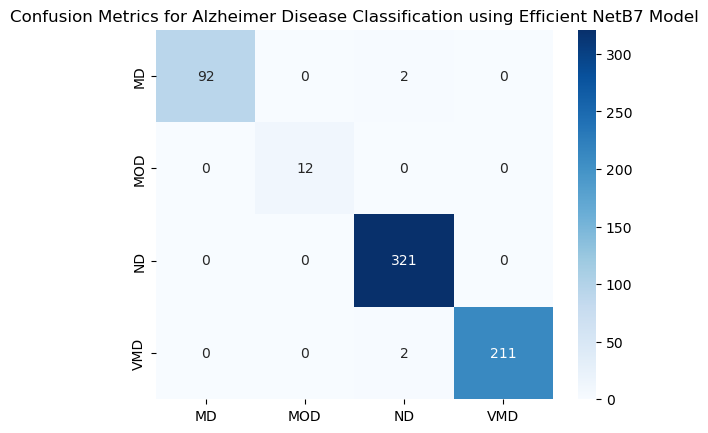

In [74]:
Cm2=confusion_matrix(actual_label2,pred2)
ax2=plt.axes()
sns.heatmap(Cm2, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax2
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Efficient NetB7 Model")
plt.savefig('netb7_confusion.png', dpi=300) # Save plot as PNG
plt.show()

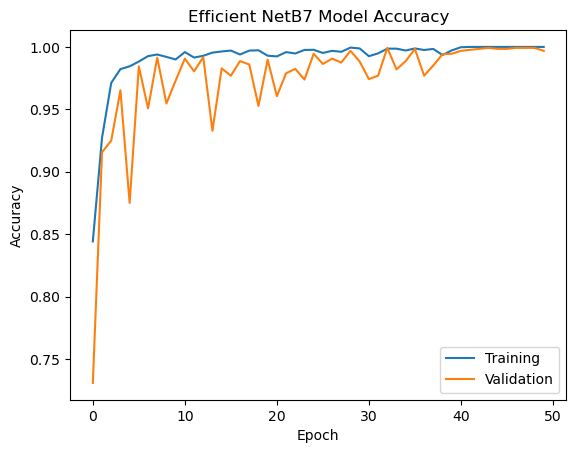

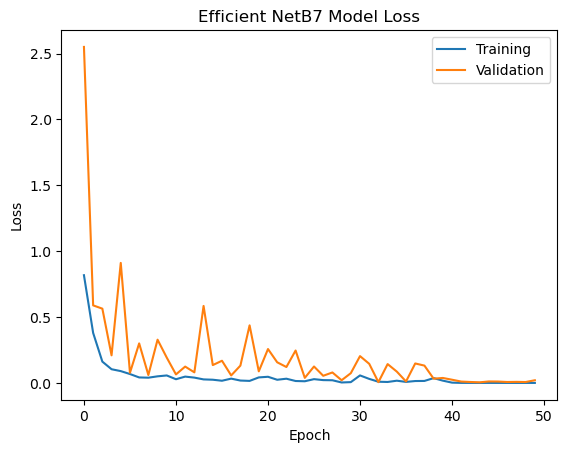

In [75]:
# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Efficient NetB7 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Efficient NetB7 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_loss.png', dpi=300) # Save plot as PNG
plt.show()

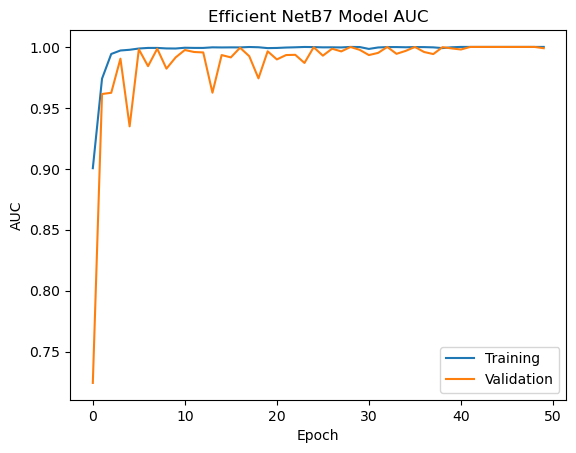

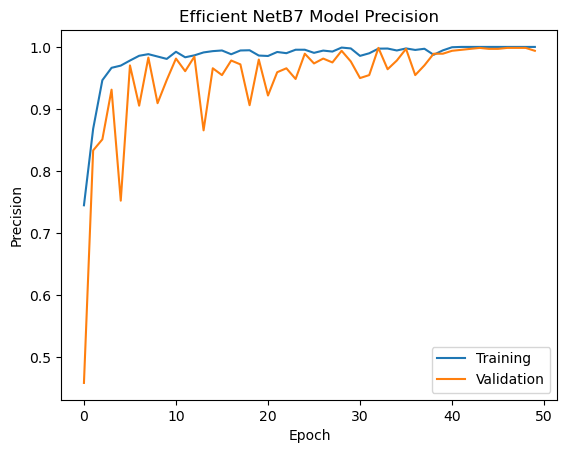

In [82]:
plt.plot(history2.history['auc'])
plt.plot(history2.history['val_auc'])
plt.title('Efficient NetB7 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history2.history['precision'])
plt.plot(history2.history['val_precision'])
plt.title('Efficient NetB7 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('Efficient NetB7_precision.png', dpi=300) # Save plot as PNG
plt.show()

# VGG19 MODEL

In [42]:
image_size = 150

In [43]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights='imagenet',
            include_top = False,input_shape=(image_size, image_size, 3)
           )
for layer in vgg.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model3 = Sequential()
model3.add(vgg)
model3.add(Flatten())
model3.add(Dense(4,activation="softmax"))
#model.summary()

80134624/80134624 [==============================] - 0s 0us/step


In [15]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 40965     
                                                                 
Total params: 20,065,349
Trainable params: 40,965
Non-trainable params: 20,024,384
_________________________________________________________________


## Compile VGG19 Model

In [44]:
model3.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [45]:
history3=model3.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))

Epoch 1/50
180/180 [==============================] - 21s 94ms/step - loss: 3.2480 - accuracy: 0.7964 - precision: 0.5938 - recall: 0.5872 - auc: 0.8012 - val_loss: 1.7350 - val_accuracy: 0.8152 - val_precision: 0.6323 - val_recall: 0.6234 - val_auc: 0.8400
Epoch 2/50
180/180 [==============================] - 16s 92ms/step - loss: 1.2425 - accuracy: 0.8537 - precision: 0.7102 - recall: 0.7009 - auc: 0.8936 - val_loss: 1.2831 - val_accuracy: 0.8461 - val_precision: 0.6965 - val_recall: 0.6812 - val_auc: 0.8840
Epoch 3/50
180/180 [==============================] - 16s 89ms/step - loss: 0.8789 - accuracy: 0.8806 - precision: 0.7642 - recall: 0.7552 - auc: 0.9269 - val_loss: 1.4495 - val_accuracy: 0.8520 - val_precision: 0.7049 - val_recall: 0.7016 - val_auc: 0.8909
Epoch 4/50
180/180 [==============================] - 16s 88ms/step - loss: 0.6648 - accuracy: 0.9021 - precision: 0.8069 - recall: 0.7997 - auc: 0.9493 - val_loss: 1.0611 - val_accuracy: 0.8664 - val_precision: 0.7358 - val_r

In [46]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history3.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/VGG_D2_19.csv', index=False)

# Save the model itself
model3.save('/kaggle/working/VGG_D2_19.h5')

In [48]:
pred3 = model3.predict(xtest)
pred3 = np.argmax(pred3, axis=1)
actual_label3 = np.argmax(ytest, axis=1)
print(classification_report(actual_label3, pred3, target_names = labels))

20/20 [==============================] - 2s 79ms/step
                  precision    recall  f1-score   support

    MildDemented       0.94      0.65      0.77        94
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       0.92      0.81      0.86       321
VeryMildDemented       0.70      0.92      0.80       213

        accuracy                           0.83       640
       macro avg       0.89      0.85      0.86       640
    weighted avg       0.85      0.83      0.83       640



In [49]:
accuracy_score(actual_label3, pred3)

0.8265625

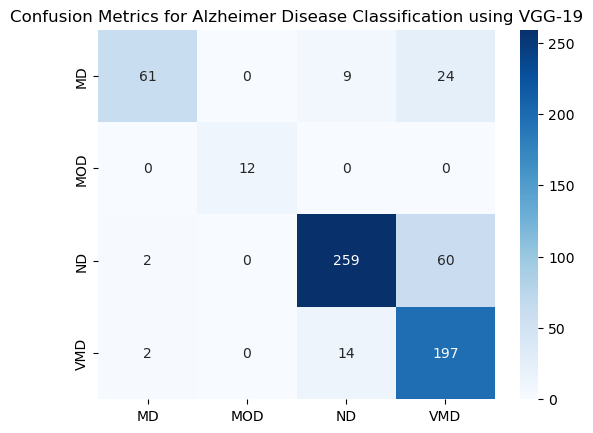

In [51]:
Cm3=confusion_matrix(actual_label3,pred3)
ax3=plt.axes()
sns.heatmap(Cm3, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using VGG-19")
plt.savefig('vgg19_confusion.png', dpi=300) # Save plot as PNG
plt.show()

ResNet 50


In [53]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [54]:
rn = ResNet50(input_shape=(150,150,3), weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [55]:
for layer in rn.layers:
    layer.trainable = False
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model4 = Sequential()
model4.add(rn)
model4.add(Flatten())
model4.add(Dense(4,activation="softmax"))

In [56]:
model4.compile( optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS)

In [57]:

history4=model4.fit(xtrain,ytrain,epochs=50,validation_data=(xtest,ytest))
#history4=model4.load_weights('/kaggle/input/h-5-files/RES_90_10.h5')

Epoch 1/50
180/180 [==============================] - 16s 63ms/step - loss: 3.0468 - accuracy: 0.8097 - precision: 0.6210 - recall: 0.6127 - auc: 0.8222 - val_loss: 1.5730 - val_accuracy: 0.8230 - val_precision: 0.6463 - val_recall: 0.6453 - val_auc: 0.8716
Epoch 2/50
180/180 [==============================] - 10s 57ms/step - loss: 0.6982 - accuracy: 0.8938 - precision: 0.7921 - recall: 0.7799 - auc: 0.9419 - val_loss: 0.9262 - val_accuracy: 0.8781 - val_precision: 0.7571 - val_recall: 0.7547 - val_auc: 0.9205
Epoch 3/50
180/180 [==============================] - 10s 57ms/step - loss: 0.4743 - accuracy: 0.9273 - precision: 0.8575 - recall: 0.8505 - auc: 0.9682 - val_loss: 0.4050 - val_accuracy: 0.9277 - val_precision: 0.8583 - val_recall: 0.8516 - val_auc: 0.9754
Epoch 4/50
180/180 [==============================] - 10s 56ms/step - loss: 0.3116 - accuracy: 0.9596 - precision: 0.9210 - recall: 0.9172 - auc: 0.9875 - val_loss: 0.5647 - val_accuracy: 0.9336 - val_precision: 0.8718 - val_r

In [58]:
import pandas as pd

# Assuming 'history1' is the History object returned from model.fit()
metrics = pd.DataFrame(history4.history)

# Save the training history to a CSV file
metrics.to_csv('/kaggle/working/RES_90.csv', index=False)

# Save the model itself
model4.save('/kaggle/working/RES_D2_90_10.h5')

In [59]:
pred4 = model4.predict(xtest)
pred4 = np.argmax(pred4, axis=1)
actual_label4 = np.argmax(ytest, axis=1)
print(classification_report(actual_label4, pred4 , target_names = labels))

20/20 [==============================] - 2s 50ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      0.95      0.96        94
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       0.97      0.97      0.97       321
VeryMildDemented       0.95      0.96      0.96       213

        accuracy                           0.96       640
       macro avg       0.97      0.97      0.97       640
    weighted avg       0.96      0.96      0.96       640



In [60]:
accuracy_score(actual_label4, pred4)

0.9640625

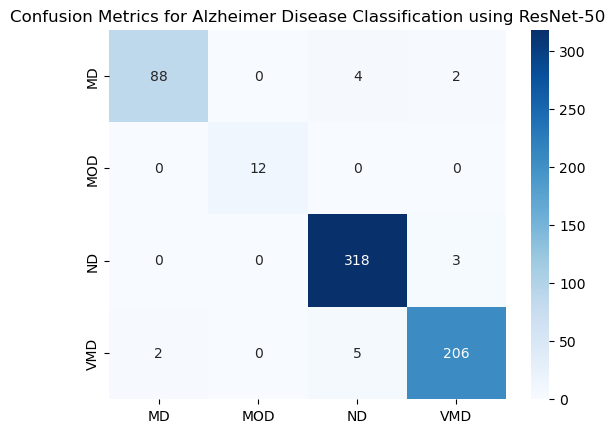

In [61]:
Cm1=confusion_matrix(actual_label1,pred1)
ax1=plt.axes()
sns.heatmap(Cm1, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax1
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using ResNet-50")
plt.savefig('res_confusion.png', dpi=300) # Save plot as PNG
plt.show()

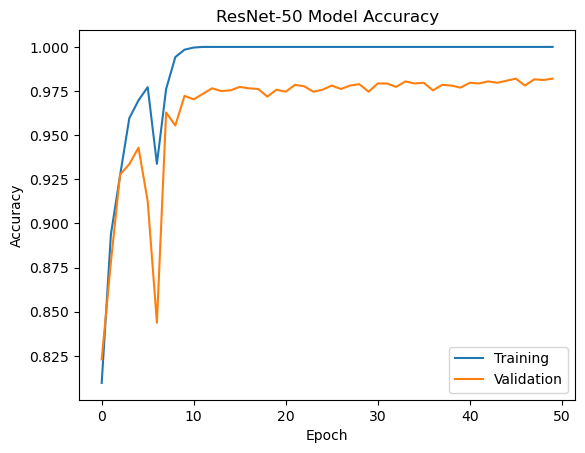

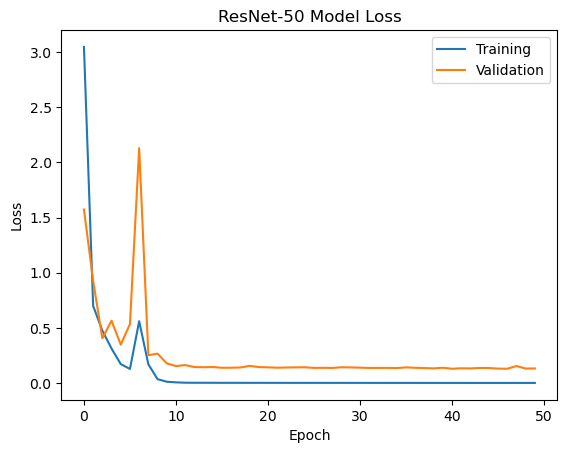

In [62]:
# Plot the training and validation accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('ResNet-50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_accuracy.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('ResNet-50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_loss.png', dpi=300) # Save plot as PNG
plt.show()

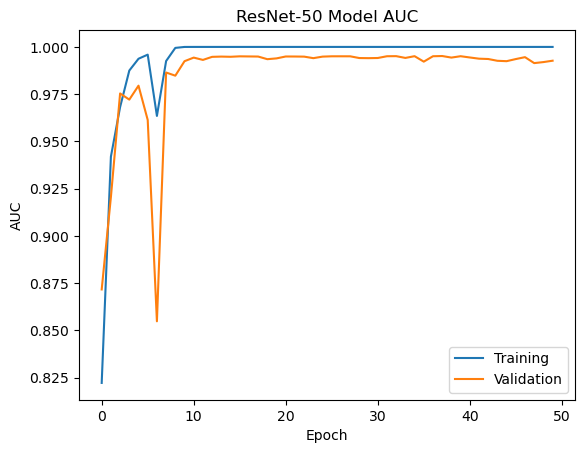

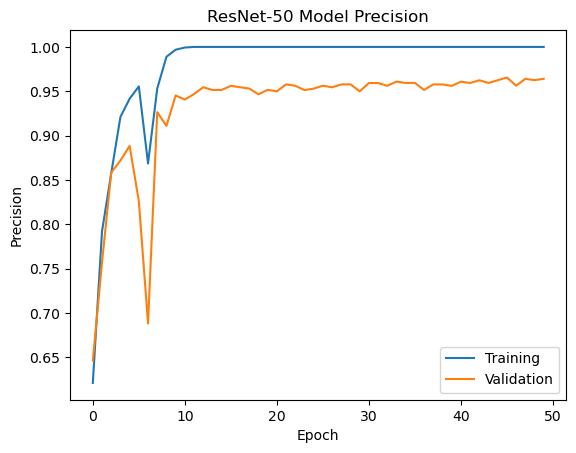

In [63]:
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('ResNet-50 Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_auc.png', dpi=300) # Save plot as PNG
plt.show()

# Plot the training and validation precision
plt.plot(history4.history['precision'])
plt.plot(history4.history['val_precision'])
plt.title('ResNet-50 Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.savefig('ResNet-50_precision.png', dpi=300) # Save plot as PNG
plt.show()

In [64]:
accuracy_score(actual_label4, pred4)

0.9640625

In [45]:
from sklearn.metrics import precision_score

precision = precision_score(actual_label4, pred4, average='weighted')

print("Precision Score:", precision)

Precision Score: 0.9641556323125541


In [83]:
scores  = model.evaluate(xtest, ytest, verbose=1)
scores1 = cnn.evaluate(xtest, ytest, verbose=1)
scores2 = model2.evaluate(xtest, ytest, verbose=1)
#scores3 = model3.evaluate(xtest, ytest, verbose=1)
scores4 = model4.evaluate(xtest, ytest, verbose=1)


20/20 [==============================] - 1s 51ms/step - loss: 0.1313 - accuracy: 0.9820 - precision: 0.9641 - recall: 0.9641 - auc: 0.9927


## Densenet 

In [84]:
precision = scores[0]
f1_score = scores[1]
recall = scores[2]
accuracy = scores[3]

## CNN 

In [85]:
precision1 = scores1[0]
f1_score1 = scores1[1]
recall1 = scores1[2]
accuracy1 = scores1[3]

## Efficient Net B7 

In [86]:
precision2 = scores2[0]
f1_score2 = scores2[1]
recall2 = scores2[2]
accuracy2 = scores2[3]

Resnet 50


In [87]:
precision4 = scores4[0]
f1_score4 = scores4[1]
recall4 = scores4[2]
accuracy4 = scores4[3]

In [88]:
import pandas as pd

eval_df = pd.DataFrame(columns=['Model','Precision', 'F1 Score', 'Recall', 'Accuracy'])


In [89]:
eval_df = eval_df.append({'Model' : 'Densenet', 'Precision': precision, 'F1 Score': f1_score, 'Recall': recall, 'Accuracy': accuracy}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'CNN', 'Precision': precision1, 'F1 Score': f1_score1, 'Recall': recall1, 'Accuracy': accuracy1}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Efficient Net B7', 'Precision': precision2, 'F1 Score': f1_score2, 'Recall': recall2, 'Accuracy': accuracy2}, ignore_index=True)
#eval_df = eval_df.append({'Model' : 'VGG 19', 'Precision': precision3, 'F1 Score': f1_score3, 'Recall': recall3, 'Accuracy': accuracy3}, ignore_index=True)
eval_df = eval_df.append({'Model' : 'Resnet50', 'Precision': precision4, 'F1 Score': f1_score4, 'Recall': recall4, 'Accuracy': accuracy4}, ignore_index=True)

In [90]:
eval_df

,Model,Precision,F1 Score,Recall,Accuracy
0,Densenet,0.004374,0.999219,0.998438,0.998438
1,CNN,0.107236,0.987500,0.975000,0.975000
2,Efficient Net B7,0.020244,0.996875,0.993750,0.993750
3,Resnet50,0.131281,0.982031,0.964063,0.964063


In [76]:
import csv
eval_df.to_csv('comparison_metrics.csv', index=False)

## Ensemble Learning

In [91]:
pred = model.predict(xtest)
pred1=cnn.predict(xtest)
pred2 = model2.predict(xtest)
pred4=model4.predict(xtest)
ensemble_preds = np.average([pred ,pred1 ,pred2 ,pred4], axis=0)
final_preds = np.argmax(ensemble_preds, axis=1)
actual_label_final = np.argmax(ytest, axis=1)
print(classification_report(actual_label_final, final_preds,target_names = labels_1))
accuracy_score(actual_label_final, final_preds)

20/20 [==============================] - 1s 47ms/step
              precision    recall  f1-score   support

          MD       1.00      0.98      0.99        94
         MOD       1.00      1.00      1.00        12
          ND       0.99      1.00      1.00       321
         VMD       1.00      1.00      1.00       213

    accuracy                           1.00       640
   macro avg       1.00      0.99      1.00       640
weighted avg       1.00      1.00      1.00       640



0.996875

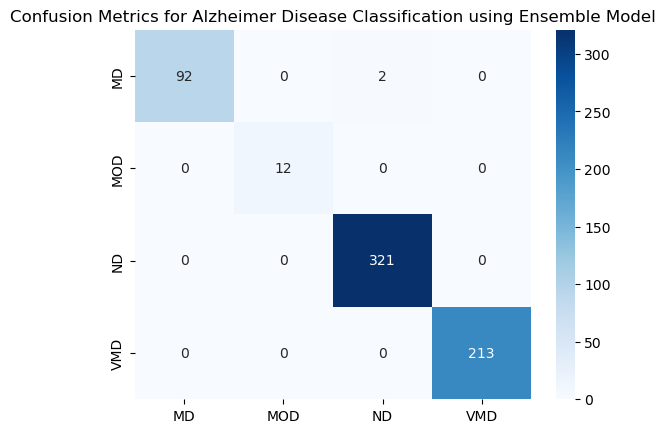

In [93]:
Cm4=confusion_matrix(actual_label_final,final_preds)
ax3=plt.axes()
sns.heatmap(Cm4, cmap='Blues' ,annot=True,fmt='d',
           annot_kws={'size':10},
           xticklabels=labels_1,
           yticklabels=labels_1,
           ax=ax3
           )

plt.title("Confusion Metrics for Alzheimer Disease Classification using Ensemble Model")
plt.savefig('ensemble_confusion_98%.png', dpi=300) # Save plot as PNG
plt.show()